# Lab 10
## Machine Learning

# Neural Networks

## Side Note: PyTorch vs TensorFlow (and others)

When building and training neural networks, there are several major libraries available. The two dominant ones are:

### PyTorch
- Developed by Facebook (Meta).
- Emphasizes **dynamic computation graphs** (eager execution), making it intuitive and easy to debug.
- Favored in **academia and research** because of its flexibility and readability.
- Widely used in educational materials and cutting-edge research papers.

### TensorFlow
- Developed by Google.
- Originally emphasized **static computation graphs** (graph execution), which can optimize performance at large scale.
- Used heavily in **industry** and **production environments** for deploying large-scale models.
- TensorFlow 2.x has improved usability, making it closer to PyTorch in style (eager execution by default).

### Other Libraries Worth Mentioning
- **JAX**: Developed by Google Research. Focused on high-performance scientific computing; often used for cutting-edge research involving automatic differentiation and massive parallelization.
- **Keras**: Originally an independent API, now tightly integrated with TensorFlow. Provides a very **high-level** interface, good for beginners or rapid prototyping.
- **Fastai**: Built on top of PyTorch. Provides **simplified workflows** for common deep learning tasks with best practices built-in.

In [2]:
# Import the Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Pytorch is the new library we will be using for fitting neural networks
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim

## Dataset: Predicting Student Dropout
The dataset contains features related to students' academic performance and other factors. The goal is to predict whether a student will drop out. More info can be found here: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success.

- **Features**: 34 columns (e.g., attendance, grades, etc.).
- **Target**: Binary classification (0 = No Dropout, 1 = Dropout).

In [3]:
# Load the dataset
df = pd.read_csv("dropoutData.csv")
df.shape

(3630, 35)

We do a Test/Training/Validation split as usual, here I have given a nice automated way to do it that does the maths for you!

In [4]:
train_ratio = 0.7 
val_ratio = 0.15
test_ratio = 0.15

# split whole into train and test, then split test into val and test
X_train, X_test, y_train, y_test = train_test_split(df.drop('Target', axis=1), df['Target'], train_size=train_ratio, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=val_ratio/(val_ratio + test_ratio), random_state=123)

We have to convert the data into numpy arrays for pytorch to work with them as nueral networks only take matrices of numbers - much of the progress in Deep Learning has been finding clever ways to encode other information as matrices of numbers - and letting models learn these representations!

In [5]:
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
X_val=X_val.to_numpy()
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()
y_val=y_val.to_numpy()

PyTorch uses tensors as its core data structure, which are similar to multidimensional arrays. Tensors are designed to easily run computations on both CPUs and GPUs, enabling much faster training for large models.

We won't look at it in depth, but in practice swtiching to GPU is as simple as adding a line like:

`device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`

and then moving tensors and models to this device:

`model = model.to(device)
tensor = tensor.to(device)`

In [7]:
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
val_dataset= TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())
test_dataset=TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())

### DataLoaders and Batch Size

When training a neural network, we rarely pass all the data through the model at once.  
Instead, we split the data into small **batches** and train on each batch separately.

**Batch Size** is a hyperparameter which controls how many samples are passed through the network before updating the weights once, it is a tradeoff between speed and accuracy:
- **Small batch size** (e.g., 16, 32): Noisy updates, faster iterations, may help generalization.
- **Large batch size** (e.g., 128, 256+): Smoother updates, better use of GPU, but can lead to worse generalization if too large.

In PyTorch, the `DataLoader` class automatically:
- **Shuffles** the data (optional),
- **Batches** the data into mini-batches,
- **Loads** the data efficiently during training (even supports parallel loading on multiple CPU cores).

In [8]:
## Setting batchsizes and creating dataloaders
train_bs = 32
val_bs = 32
test_bs = 32

train_dataloader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True, drop_last=True) #dataset
val_dataloader = DataLoader(val_dataset, batch_size=val_bs, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_bs, shuffle=False, drop_last=True)

print(f'No. of batches train dataloader: {len(train_dataloader)} and total train samples: {len(train_dataloader)*train_bs}, {train_dataloader.batch_size}')
print(f'No. of batches val dataloader: {len(val_dataloader)} and total val samples: {len(val_dataloader)*val_bs}')
print(f'No. of batches test dataloader: {len(test_dataloader)} and test train samples: {len(test_dataloader)*test_bs}')

No. of batches train dataloader: 79 and total train samples: 2528, 32
No. of batches val dataloader: 17 and total val samples: 544
No. of batches test dataloader: 17 and test train samples: 544


### Training and Testing Neural Networks

Here we manually write the loops for training and testing our neural networks.  While higher-level libraries can automate this, it’s important to first understand what is happening in detail to see how gradients flow and update the weights and because we often have to customise and debug these steps for particular problems.

Each training step follows this cycle:

1. **Forward Pass** — make predictions.
2. **Compute Loss** — measure how wrong the predictions are.
3. **Backward Pass** — calculate gradients (backpropagation).
4. **Update Weights** — adjust parameters to reduce the error.
5. **Zero Gradients** — clear old gradients before the next step.

Below, we'll define simple `train_loop` and `test_loop` functions that handle these steps. Try to understand what is happening in each line!

In [9]:
def train_loop(model, tr_dataloader, loss_fn, opt):
    avg_loss = 0 # to store running loss
    model.train() # Set model in training mode
    for batch_idx, (X, y) in enumerate(tr_dataloader):
        pred = model(X) # make prediction on current batch
        loss = loss_fn(pred,y) # calculate loss
        loss.backward() # calculates gradients
        opt.step() # update weights
        opt.zero_grad() # set gradients to zero for next batch
        avg_loss += loss.item()
        #print(f'Batch no. {batch_idx}, Batch loss: {loss.item():.5f}')
    print(f'Average training Loss: {avg_loss/len(tr_dataloader):.5f}')
    train_loss = avg_loss/len(tr_dataloader)
    return train_loss

def test_loop(model, dataloader, loss_fn ):
    test_loss = 0.
    correct = 0
    model.eval()
    bs = dataloader.batch_size
    for batch_idx, (X, y) in enumerate(dataloader):
        pred = model(X) # make prediction on current batch
        test_loss += loss_fn(pred,y).item() # calculate loss
        correct += (pred.argmax(1) == y).type(torch.float).sum().item() # not required for regression

    test_loss /= len(dataloader)
    correct /= (len(dataloader)*dataloader.batch_size)
    print(f'Error: \n Accuracy: {(100*correct):0.1f}%, Avg test loss: {test_loss:.5f} \n')

    return test_loss

I also define a function to make plotting the loss quicker.

In [10]:
def plot_loss(train_loss, val_loss, epochs):
    xax = range(epochs)
    plt.plot(xax, np.array(train_loss),'r-', xax, np.array(val_loss),'g-'  )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train loss','Val loss' ])
    plt.show()

### Neural Network Architecture

One of the most important aspects of designing a neural network is deciding its **architecture** — that is, how many layers it will have, how many neurons in each layer, and how they are connected.

A basic neural network consists of three types of layers:

- **Input Layer**:  
  The first layer of the network. Each neuron in this layer corresponds to one feature of the input data.  
  For example, if your input data has 2 features (like coordinates \(x_1\) and \(x_2\)), the input layer will have 2 neurons.

- **Hidden Layers**:  
  These layers sit between the input and output layers and perform most of the computation.  
  Each hidden neuron computes a weighted sum of its inputs, adds a bias, and passes the result through an activation function.  
  A network can have any number hidden layers. Deeper networks (with more hidden layers) can often learn very complex patterns efficiently - but are harder to train. More 

- **Output Layer**:  
  The final layer of the network. It produces the network's prediction.  
  The number of neurons here depends on the task:
  - **Binary classification** → 1 neuron (with a sigmoid activation).
  - **Multi-class classification** → One neuron per class (with softmax activation).
  - **Regression** → 1 neuron (typically no activation or a linear activation).

Below we define a small feedforward neural network with one hidden layer, using `nn.Sequential` to stack layers and ReLU activation.  
The network maps 34 input features to 2 output classes (for classification).

In [11]:
class Network(nn.Module):
    def __init__(self,hid_layer=[100]):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(34, hid_layer[0]),
            nn.ReLU(),
            nn.Linear(hid_layer[0], 2)
        )
    def forward(self,x):
        logits = self.net(x)
        return logits

### Training Setup and Hyperparameter selection

We now set up the model instance we will train:

- **Hidden Layer**: We only have one hidden layer in this model, I select 80 nodes as that should be plenty.
- **Epochs**: This is the number of full passes through the training data we will perform, we want to make sure this is long enough to reach convergence.
- **Learning Rate**: Another hyperparameter we can tune, I use 0.02 as mentioned in the slides to start - we will also tweak this based on how convergence looks in our loss plot.
- **Loss Function**: Cross-entropy (as we are doing binary classification).
- **Optimizer**: Adam - a very powerful and common optimiser.

We store the training and validation losses after each epoch to visualize learning.

The loop below trains the model and evaluates it on the validation set after each epoch.

Epoch 0
Average training Loss: 0.47623
Error: 
 Accuracy: 91.5%, Avg test loss: 0.23387 

Epoch 1
Average training Loss: 0.30698
Error: 
 Accuracy: 89.7%, Avg test loss: 0.24993 

Epoch 2
Average training Loss: 0.27095
Error: 
 Accuracy: 89.9%, Avg test loss: 0.25971 

Epoch 3
Average training Loss: 0.28578
Error: 
 Accuracy: 92.5%, Avg test loss: 0.20960 

Epoch 4
Average training Loss: 0.26971
Error: 
 Accuracy: 91.5%, Avg test loss: 0.22924 

Epoch 5
Average training Loss: 0.26858
Error: 
 Accuracy: 92.6%, Avg test loss: 0.23007 

Epoch 6
Average training Loss: 0.25031
Error: 
 Accuracy: 92.5%, Avg test loss: 0.23462 

Epoch 7
Average training Loss: 0.23798
Error: 
 Accuracy: 93.0%, Avg test loss: 0.22096 

Epoch 8
Average training Loss: 0.23637
Error: 
 Accuracy: 87.9%, Avg test loss: 0.30144 

Epoch 9
Average training Loss: 0.27093
Error: 
 Accuracy: 92.5%, Avg test loss: 0.20002 

Epoch 10
Average training Loss: 0.26657
Error: 
 Accuracy: 91.7%, Avg test loss: 0.22092 

Epoch 11


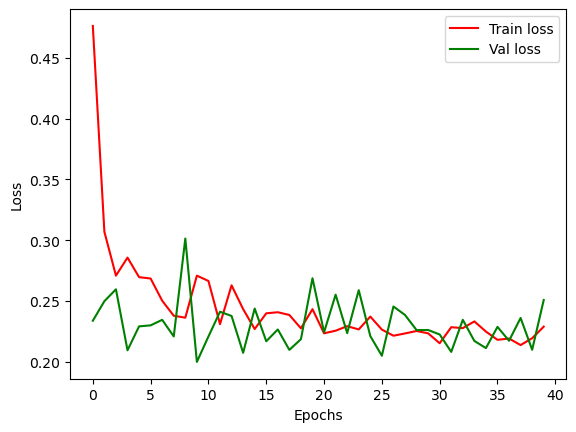

In [12]:
hid_layer = [80] # number of nodes
model = Network(hid_layer) # the model object is an instance of the class Network

# Hyperparameters
epochs = 40
learning_rate = 2e-2 
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)
train_loss = [] # list to store train loss
val_loss = [] # list to store val loss

for t in range(epochs):
    print(f'Epoch {t}')
    train_loss.append(train_loop(model, train_dataloader,  loss_fn, opt)) # to plot the graph
    val_loss.append(test_loop(model, val_dataloader, loss_fn))

# plot the loss
plot_loss(train_loss, val_loss, epochs)

In [13]:
print('Performing test...\n')
test_loop(model,test_dataloader,loss_fn)

Performing test...

Error: 
 Accuracy: 87.9%, Avg test loss: 0.47138 



0.4713827801101348

### Adding Dropout for Regularization

To reduce overfitting, we introduce **dropout layers**.  
Dropout randomly "switches off" neurons during training, forcing the model to build more robust features.

The `NetworkWithDropout` class below adds dropout after each hidden layer, as well as increasing the number of layers to two. We set:

- **Dropout Rate**: 0.5 (proportion of neurons randomly dropped during training).

In [14]:
class NetworkWithDropout(nn.Module):
    def __init__(self, hid_layer=[100, 100], dropout_rate=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(34, hid_layer[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout layer
            nn.Linear(hid_layer[0], hid_layer[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout layer
            nn.Linear(hid_layer[1], 2),
        )

    def forward(self, x):
        logits = self.net(x)
        return logits

### Weight Decay, and Early Stopping

Other common regularization techniques are:

- **Weight Decay**: Adds a penalty for large weights directly into the optimizer.
- **Early Stopping**: Stops training once validation loss stops improving.

These help the model generalize better to unseen data.

Epoch 0
Average training Loss: 0.69788
Error: 
 Accuracy: 83.6%, Avg test loss: 0.43835 

Epoch 1
Average training Loss: 0.48649
Error: 
 Accuracy: 88.2%, Avg test loss: 0.33470 

Epoch 2
Average training Loss: 0.42417
Error: 
 Accuracy: 88.2%, Avg test loss: 0.31216 

Epoch 3
Average training Loss: 0.38839
Error: 
 Accuracy: 89.2%, Avg test loss: 0.28407 

Epoch 4
Average training Loss: 0.34669
Error: 
 Accuracy: 89.3%, Avg test loss: 0.27329 

Epoch 5
Average training Loss: 0.34932
Error: 
 Accuracy: 89.5%, Avg test loss: 0.26416 

Epoch 6
Average training Loss: 0.32899
Error: 
 Accuracy: 90.3%, Avg test loss: 0.25290 

Epoch 7
Average training Loss: 0.31289
Error: 
 Accuracy: 90.4%, Avg test loss: 0.23876 

Epoch 8
Average training Loss: 0.30277
Error: 
 Accuracy: 90.8%, Avg test loss: 0.23647 

Epoch 9
Average training Loss: 0.29377
Error: 
 Accuracy: 91.7%, Avg test loss: 0.23027 

Epoch 10
Average training Loss: 0.28871
Error: 
 Accuracy: 91.4%, Avg test loss: 0.22669 

Epoch 11


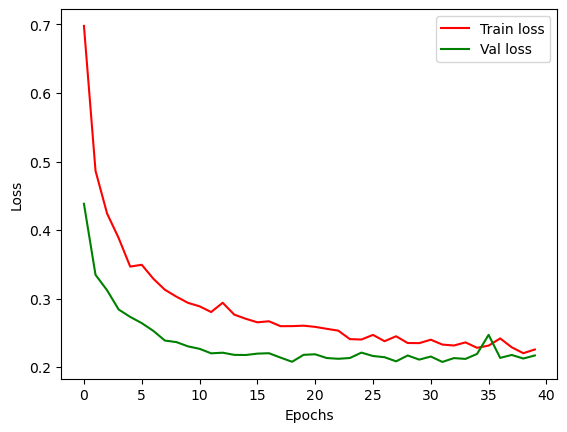

In [15]:
hid_layer2 = [80,45] # number of nodes in the hidden layers, we have 2 hidden layers now so we need to specify the number of nodes in both layers
dropout_rate = 0.5 # Hyperparameter
model2 = NetworkWithDropout(hid_layer2, dropout_rate=dropout_rate) #instantiate

#Hyperparameters
epochs = 40 
learning_rate = 1e-3 
weight_decay = 1e-5 # L2 regularization

loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_loss = [] # list to store train loss
val_loss = [] # list to store val loss

for t in range(epochs):
    print(f'Epoch {t}')
    train_loss.append(train_loop(model2, train_dataloader,  loss_fn, opt)) # to plot the graph
    val_loss.append(test_loop(model2, val_dataloader, loss_fn))
    
# plot the loss
plot_loss(train_loss, val_loss, epochs)

In [16]:
print('Performing test...\n')
test_loop(model2,test_dataloader,loss_fn)

Performing test...

Error: 
 Accuracy: 89.5%, Avg test loss: 0.32769 



0.32768985892043395

Now it is your turn! Experiment with changing the architecture and see what sort of . Try to make one model that *overfits*, one that *underfits* and one that beats my models performance above!

> 💡 **Tip:**  
> Adding more neurons or more layers can make a network more powerful — but also **easier to overfit**.  
> 
> Good practice is to start with a **small network** and make it larger only if necessary.  

Epoch 0
Average training Loss: 0.56897
Error: 
 Accuracy: 85.3%, Avg test loss: 0.34735 

Epoch 1
Average training Loss: 0.41061
Error: 
 Accuracy: 89.0%, Avg test loss: 0.28051 

Epoch 2
Average training Loss: 0.36376
Error: 
 Accuracy: 89.3%, Avg test loss: 0.28282 

Epoch 3
Average training Loss: 0.33605
Error: 
 Accuracy: 90.8%, Avg test loss: 0.25318 

Epoch 4
Average training Loss: 0.31913
Error: 
 Accuracy: 91.9%, Avg test loss: 0.24400 

Epoch 5
Average training Loss: 0.30734
Error: 
 Accuracy: 91.5%, Avg test loss: 0.22596 

Epoch 6
Average training Loss: 0.29290
Error: 
 Accuracy: 91.7%, Avg test loss: 0.22198 

Epoch 7
Average training Loss: 0.28666
Error: 
 Accuracy: 91.4%, Avg test loss: 0.21856 

Epoch 8
Average training Loss: 0.28768
Error: 
 Accuracy: 91.7%, Avg test loss: 0.23045 

Epoch 9
Average training Loss: 0.27089
Error: 
 Accuracy: 90.4%, Avg test loss: 0.22726 

Epoch 10
Average training Loss: 0.26707
Error: 
 Accuracy: 91.2%, Avg test loss: 0.21387 

Epoch 11


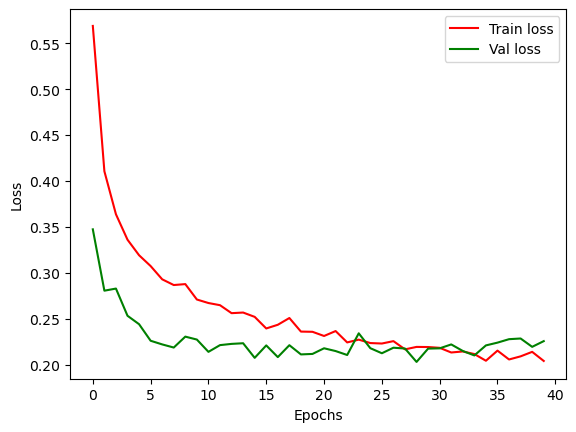

In [53]:
#overfitting model

hid_layer2 = [80,45,40] # number of nodes in the hidden layers, we have 2 hidden layers now so we need to specify the number of nodes in both layers
dropout_rate = 0.30 # Hyperparameter changed from 50 % to 10%
model3 = NetworkWithDropout(hid_layer2, dropout_rate=dropout_rate) #instantiate

#Hyperparameters
epochs = 40 
learning_rate = 1e-3 #changed from 1e-3 to 1e-7 
weight_decay = 1e-5 # L2 regularization



loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model3.parameters(), lr=learning_rate)
train_loss = [] # list to store train loss
val_loss = [] # list to store val loss

for t in range(epochs):
    print(f'Epoch {t}')
    train_loss.append(train_loop(model3, train_dataloader,  loss_fn, opt)) # to plot the graph
    val_loss.append(test_loop(model3, val_dataloader, loss_fn))
    
# plot the loss
plot_loss(train_loss, val_loss, epochs)



In [54]:
print('Performing test...\n')
test_loop(model3,test_dataloader,loss_fn)

Performing test...

Error: 
 Accuracy: 87.7%, Avg test loss: 0.34363 



0.34363025076249065

In [ ]:
#original is 88.1 and .345
# lower dropout rate gives higher overfitting but tiny bit more acuracy
#lower learn rate acc went down alot and loss up alot. same with too low of learning rate. 
#higher epoch raised accuracy and lowered loss a bit (about 1% each direction)(acc87.1 and loss.342)
#now at 88.4 and .344
#taking out regularization raises accuracy but increased test loss (88.4 and .334)


In [ ]:
#overfitting model

hid_layer2 = [80,45] # number of nodes in the hidden layers, we have 2 hidden layers now so we need to specify the number of nodes in both layers
dropout_rate = 0.50 # Hyperparameter changed from 50 % to 10%
model3 = NetworkWithDropout(hid_layer2, dropout_rate=dropout_rate) #instantiate

#Hyperparameters
epochs = 40 
learning_rate = 1e-3 #changed from 1e-3 to 1e-7 
weight_decay = 1e-5 # L2 regularization

loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model3.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_loss = [] # list to store train loss
val_loss = [] # list to store val loss

for t in range(epochs):
    print(f'Epoch {t}')
    train_loss.append(train_loop(model3, train_dataloader,  loss_fn, opt)) # to plot the graph
    val_loss.append(test_loop(model3, val_dataloader, loss_fn))
    
# plot the loss
plot_loss(train_loss, val_loss, epochs)